In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Modules

In [1]:
! pip install bs4 lxml kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=60b26811cc278c1d9bae2b6e01c0240f908d8f81bb5e063ee3ae18cf2feab748
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [5]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.3 MB/s eta 0:00:00


# Download Dataset from Kaggle

In [6]:
import os
os.environ['KAGGLE_USERNAME'] = 'bilalyousaf0014'
os.environ['KAGGLE_KEY'] = '11031bc21c5e3ec23585dbe17dc4267d'

In [7]:
!kaggle datasets download -d bilalyousaf0014/ml-engineer-assessment-dataset

100% 78.6M/78.6M [00:03<00:00, 31.3MB/s]
100% 78.6M/78.6M [00:03<00:00, 22.9MB/s]


In [8]:
! unzip /content/ml-engineer-assessment-dataset.zip

Archive:  /content/ml-engineer-assessment-dataset.zip
  inflating: assessment_dataset/images/00001.jpeg  
  inflating: assessment_dataset/images/00008.jpeg  
  inflating: assessment_dataset/images/00017.jpeg  
  inflating: assessment_dataset/images/00022.jpeg  
  inflating: assessment_dataset/images/00048.jpeg  
  inflating: assessment_dataset/images/00055.jpeg  
  inflating: assessment_dataset/images/001.jpeg  
  inflating: assessment_dataset/images/1.jpeg  
  inflating: assessment_dataset/images/1001524.jpeg  
  inflating: assessment_dataset/images/1005343.jpeg  
  inflating: assessment_dataset/images/1049854.jpeg  
  inflating: assessment_dataset/images/1072860.jpeg  
  inflating: assessment_dataset/images/1120419.jpeg  
  inflating: assessment_dataset/images/1146885.jpeg  
  inflating: assessment_dataset/images/2.jpeg  
  inflating: assessment_dataset/images/3.jpeg  
  inflating: assessment_dataset/images/4.jpeg  
  inflating: assessment_dataset/images/5.jpeg  
  inflating: assessm

# Importing Required Libraries

In [24]:
import os
import torch
import torch.nn as nn
import numpy as np

from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
import torchmetrics
from bs4 import BeautifulSoup


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb
from PIL import ImageDraw
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

import torchvision.transforms as transforms
from torch.utils.data import DataLoader



# ENCODING ANIMAL AND SPECIES CLASS (GLOBAL_VARIABLE)

In [29]:
SPECIES = ['Abyssinian', 'Birman', 'Persian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'chihuahua', 'pomeranian', 'NA']
SPECIES_TO_INDEX = {specie: index for index, specie in enumerate(SPECIES)}
SPECIES_TO_INDEX


CAT_OR_DOG = ['cat', 'dog', 'NA']
CAT_OR_DOG_TO_INDEX = {cat_or_dog: index for index, cat_or_dog in enumerate(CAT_OR_DOG)}
CAT_OR_DOG_TO_INDEX

{'cat': 0, 'dog': 1, 'NA': 2}

# CUSTOM DATALOADER IMPLEMENTATION

In [10]:

train_list = np.load('/content/assessment_dataset/train_list.npy', allow_pickle=True).tolist()
val_list = np.load('/content/assessment_dataset/val_list.npy', allow_pickle=True).tolist()

In [11]:
len(train_list)

832

In [276]:
len(val_list)

208

In [5]:

def read_xml_file(path):
    with open(path, 'r') as f:
        data = f.read()
    bs_data = BeautifulSoup(data, 'xml')
    return {
        "has_object": True,
        "cat_or_dog": bs_data.find("name").text,
        "xmin": int(bs_data.find("xmin").text),
        "ymin": int(bs_data.find("ymin").text),
        "xmax": int(bs_data.find("xmax").text),
        "ymax": int(bs_data.find("ymax").text),
        "specie": "_".join(path.split(os.sep)[-1].split("_")[:-1])
    }

## Visualizing the images

In [191]:
# test the bounding boxes
test_xml = read_xml_file('/content/assessment_dataset/labels/Abyssinian_152.xml')
test_xml = read_xml_file('/content/assessment_dataset/labels/pomeranian_117.xml')

In [192]:
test_xml

{'has_object': True,
 'cat_or_dog': 'dog',
 'xmin': 140,
 'ymin': 4,
 'xmax': 236,
 'ymax': 128,
 'specie': 'pomeranian'}

In [199]:

def visualize_original(image_name, image_folder_path, output_folder="output"):

  image_path = os.path.join(image_folder_path, image_name+".jpg")
  image = Image.open(image_path)

  # Preprocessing
  preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

  input_tensor = preprocess(image)
  input_batch = input_tensor.unsqueeze(0)

  bbox = [test_xml['xmin'],test_xml['ymin'],test_xml['xmax'],test_xml['ymax']]
 

  have_object = test_xml['has_object']
  cat_or_dog = test_xml['cat_or_dog']
  species_name = test_xml['specie']

  fig, ax = plt.subplots(1)
  ax.imshow(image)

  if have_object:
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.text(10, 10, 'Specie: {} Cat or Dog: {}'.format(species_name, cat_or_dog), color='white', 
             bbox=dict(facecolor='red', alpha=0.5))

  #plt.savefig(os.path.join(output_folder, image_name + ".png"))

  return 


In [200]:
outputs = '/content/drive/MyDrive/mtailor/output/'
#model_weights = f"{model_path}/best_model.pth"
image_folder_path = '/content/assessment_dataset/images/'
image_name = 'pomeranian_117'
#image_name = 'Abyssinian_10'

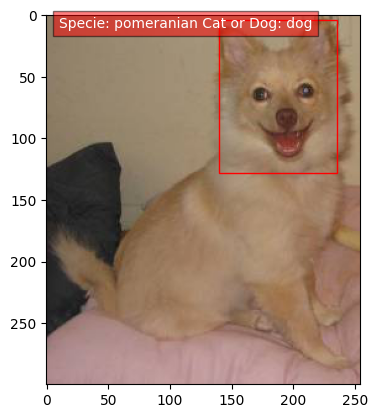

In [201]:
visualize_original(image_name, image_folder_path, output_folder="output")

# Custom Dataset

In [282]:


class CustomDataset():
  def __init__(self, dataset_path, images_list, train=False):
    self.train = train
    self.dataset_path = dataset_path
    self.images_list = images_list
    self.image_folder_path = os.path.join(dataset_path, "images")
    self.label_folder_path = os.path.join(dataset_path, "labels")

    self.preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
       ])


    self.data = []
    for path in os.listdir(self.image_folder_path):
        name = path.split(os.sep)[-1].split(".")[0]
        if name in images_list:
          image_path = os.path.join(self.image_folder_path, path)  # Here use the actual file name, not the 'name'
          xml_path = os.path.join(self.label_folder_path, name+".xml")
          xml_data = read_xml_file(xml_path) if os.path.isfile(xml_path) else self.default_xml_data()
          self.data.append((image_path, xml_data))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_path, labels = self.data[index]
    image = Image.open(image_path)
    if self.preprocess is not None:
        image = self.preprocess(image)

    bbox = torch.tensor([labels["xmin"], labels["ymin"], labels["xmax"], labels["ymax"]]) # xmin, ymin, xmax, ymax
    has_object = torch.tensor(1 if labels["has_object"] else 0, dtype=torch.float32)  # Assuming binary classification here
    cat_or_dog = torch.tensor(CAT_OR_DOG_TO_INDEX[labels["cat_or_dog"]], dtype=torch.long)  # Map species name to integer and convert to tensor
    specie = torch.tensor(SPECIES_TO_INDEX[labels["specie"]], dtype=torch.long)  # Map species name to integer and convert to tensor

    # Return as a dictionary
    labels = {"bbox": bbox, "has_object": has_object, "cat_or_dog": cat_or_dog, "specie": specie}
    return image, labels

  def default_xml_data(self):
    # Return default dictionary in case there is no object in the image
    return {
        "has_object": False,
        "cat_or_dog": "NA",
        "specie": "NA",
        "xmin": 0,
        "ymin": 0,
        "xmax": 0,
        "ymax": 0
    }


# MODEL IMPLEMENTATION:

In [18]:
class Model(nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    pretrained_model = resnet18(pretrained=True)
    pretrained_model = resnet50(weights=ResNet50_Weights.DEFAULT)
    self.backbone = nn.Sequential(*list(pretrained_model.children())[:-2])

    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.dropout = nn.Dropout(0.5)
    
    num_features = 2048

    # Fully connected layers for each task
    self.have_object = nn.Linear(num_features, 1)  # binary classification
    self.cat_or_dog = nn.Linear(num_features, 3)  # multi-class classification
    self.specie = nn.Linear(num_features, 10)  # multi-class classification
    self.bbox = nn.Linear(num_features, 4)  # bounding box regression
  

  def forward(self, input):
    out_backbone = self.backbone(input)
    out_backbone = self.avg_pool(out_backbone)
    out_backbone = self.dropout(out_backbone)
    out_backbone = out_backbone.view(out_backbone.size(0), -1)  # Flatten

    have_object = torch.sigmoid(self.have_object(out_backbone))
    cat_or_dog = torch.softmax(self.cat_or_dog(out_backbone), dim=-1)

    specie = torch.sigmoid(self.specie(out_backbone))
    bbox = torch.sigmoid(self.bbox(out_backbone))

    return {
      "bbox": bbox,
      "object": have_object,
      "cat_or_dog": cat_or_dog,
      "specie": specie
    }


In [294]:
model = Model()
model

Model(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

# TRAINING LOOP IMPLEMENTATION

## Initializations

In [14]:
MODEL_PATH = '/content/drive/MyDrive/mtailor/models/'
BATCH_SIZE = 32
training_dataset = CustomDataset("/content/assessment_dataset", images_list=train_list)
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training Loop

In [ ]:


def train(epochs, model_weights=None):

  # Initialize Model and Optimizer
  model = Model()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Initialize Loss Functions
  have_object_loss = torch.nn.BCEWithLogitsLoss()
  specie_loss = torch.nn.CrossEntropyLoss()
  cat_or_dog_loss = torch.nn.CrossEntropyLoss()
  bbox_loss = torch.nn.SmoothL1Loss()

  training_dataset = CustomDataset("/content/assessment_dataset", images_list=train_list)
  training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

  if model_weights is not None:
      model.load_state_dict(torch.load(model_weights))

  if torch.cuda.is_available():
    model = model.cuda()

  best_val_metric = float('-inf')  # Variable to track the best validation metric score
  scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)


  def train_one_epoch(epoch_index):
      running_loss = 0.
      last_loss = 0.

      # Set model to training mode
      model.train()

      # Loop over each batch from the training set
      for i, data in enumerate(training_loader):
          # Unpack the inputs from our dataloader
          inputs, labels = data
          inputs = inputs.cuda()

          # Forward pass
          outputs = model(inputs)
          
          # Zero the gradients
          optimizer.zero_grad()

          # Compute loss
          loss_have_object = have_object_loss(outputs["object"].view(-1), labels["has_object"].cuda())
          loss_have_object = loss_have_object.sum()

          loss_specie = specie_loss(outputs["specie"], labels["specie"].cuda())
          loss_specie = loss_specie.sum()

          loss_cat_or_dog = cat_or_dog_loss(outputs["cat_or_dog"], labels["cat_or_dog"].cuda())
          loss_cat_or_dog = loss_cat_or_dog.sum()

          loss_bbox = bbox_loss(outputs["bbox"], labels["bbox"].cuda())
          loss_bbox = loss_bbox.sum()

          # Consolidate losses
          loss = loss_have_object + loss_specie + loss_cat_or_dog + loss_bbox

          # Check if the result tensor requires gradient
          if loss.requires_grad:
            # Compute gradients and perform backpropagation
            loss.backward()

          # Perform optimization
          optimizer.step()

          # Gather data and report
          running_loss += loss.item()
          if i % 10 == 0:
              last_loss = running_loss / 10 # loss per batch
              running_loss = 0.
      return last_loss

  for i in range(epochs):
    epoch_loss = train_one_epoch(i)
    print(f' Epoch {i} Train Loss : {epoch_loss}')

    metrics = validation(model, val_list)

    val_loss, val_object, val_cat_or_dog, val_specie, val_bbox = metrics

    val_metric  = val_object + val_cat_or_dog + val_specie + val_bbox

    if val_metric > best_val_metric:
      best_val_metric = val_metric
      torch.save(model.state_dict(), f"{MODEL_PATH}/best_model.pth")

    scheduler.step(best_val_metric)  # Adjust learning rate based on validation metric

    print(metrics)


def validation(model, val_list):
    model.eval()
    running_loss = 0.0
    val_dataset = CustomDataset("/content/assessment_dataset", images_list=val_list)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    

    # Set model to evaluation mode
    model.eval()
    metric_object = torchmetrics.Accuracy(task='binary').cuda()
    metric_cat_or_dog = torchmetrics.Accuracy(task='multiclass', num_classes=3).cuda()
    metric_specie = torchmetrics.Accuracy(task='multiclass', num_classes=10).cuda()
    metric_bbox = torchmetrics.MeanAbsoluteError().cuda()


    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs = inputs.cuda()

            outputs = model(inputs)
            metric_object(outputs["object"].view(-1), labels["has_object"].cuda())
            metric_cat_or_dog(outputs["cat_or_dog"], labels["cat_or_dog"].cuda())
            metric_specie(outputs["specie"], labels["specie"].cuda())
            metric_bbox(outputs["bbox"], labels["bbox"].cuda())

    score_object = metric_object.compute()
    score_cat_or_dog = metric_cat_or_dog.compute()
    score_specie = metric_specie.compute()
    score_bbox = metric_bbox.compute()

    return score_object, score_cat_or_dog, score_specie, score_bbox



In [ ]:
NUM_EPOCHS = 200
train(NUM_EPOCHS, model_weights=None)

# Loading Model from the given weight to continue training

In [ ]:
NUM_EPOCHS = 20
train(NUM_EPOCHS, model_weights=f"{MODEL_PATH}/best_model.pth")

# Visualizing Model Outputs

In [30]:
def visualize(model_weights, image_names, image_folder_path, output_folder="output"):

    model = Model()
    model.load_state_dict(torch.load(model_weights, map_location=torch.device('cpu')))
    model.eval()
    results = {}

    for image_name in image_names:
        try:
          image = Image.open(os.path.join(image_folder_path, image_name+".jpg"))
        except:
          image = Image.open(os.path.join(image_folder_path, image_name+".jpeg"))

        # Preprocessing
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)

        input_batch = input_batch.to('cpu')  # Move input tensor to CPU

        with torch.no_grad():
            output = model(input_batch)

        bbox = output['bbox'].cpu().numpy()
        bbox = bbox.squeeze()  # Remove any extra dimensions
        bbox = bbox.tolist()  # Convert to a list

        have_object = output['object'].item() > 0.5

        cat_or_dog_index = output['cat_or_dog'].argmax(dim=1).item()
        cat_or_dog = next(key for key, value in CAT_OR_DOG_TO_INDEX.items() if value == cat_or_dog_index)

        species_index = output['specie'].argmax(dim=1).item()
        species_name = next(key for key, value in SPECIES_TO_INDEX.items() if value == species_index)

        fig, ax = plt.subplots(1)
        ax.imshow(image)

        image_name_ = image_name + ".jpg"

        values = {
            'has_object': have_object,
            'cat_or_dog': cat_or_dog,
            'specie': species_name,
            'xmin': bbox[0],
            'ymin': bbox[1],
            'xmax': bbox[2],
            'ymax': bbox[3]
        }
       
        results[image_name_] = values

    return results


In [31]:
outputs = '/content/drive/MyDrive/mtailor/output/'
model_weights = f"{MODEL_PATH}/best_model.pth"
image_folder_path = '/content/assessment_dataset/images/'

In [32]:
images = ['pomeranian_117' , 'pomeranian_114']

{'pomeranian_117.jpg': {'has_object': True,
  'cat_or_dog': 'dog',
  'specie': 'Birman',
  'xmin': 0.4703121483325958,
  'ymin': 0.5065815448760986,
  'xmax': 0.5134862661361694,
  'ymax': 0.5505483746528625},
 'pomeranian_114.jpg': {'has_object': False,
  'cat_or_dog': 'cat',
  'specie': 'pomeranian',
  'xmin': 0.49509912729263306,
  'ymin': 0.497806191444397,
  'xmax': 0.5094975829124451,
  'ymax': 0.5157261490821838}}

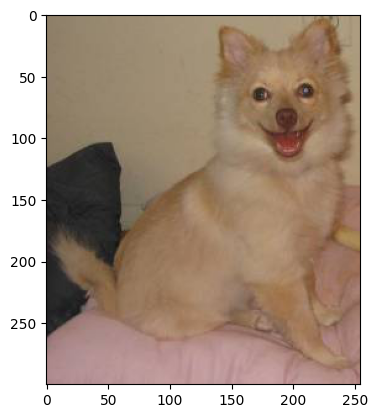

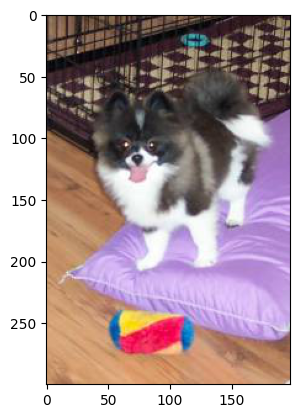

In [33]:
output = visualize(model_weights, images, image_folder_path, output_folder=outputs)
output

In [34]:
output

{'pomeranian_117.jpg': {'has_object': True,
  'cat_or_dog': 'dog',
  'specie': 'Birman',
  'xmin': 0.4703121483325958,
  'ymin': 0.5065815448760986,
  'xmax': 0.5134862661361694,
  'ymax': 0.5505483746528625},
 'pomeranian_114.jpg': {'has_object': False,
  'cat_or_dog': 'cat',
  'specie': 'pomeranian',
  'xmin': 0.49509912729263306,
  'ymin': 0.497806191444397,
  'xmax': 0.5094975829124451,
  'ymax': 0.5157261490821838}}